# [초급 프로젝트] 4팀_김명환

---
---

# 프로그래밍

In [1]:
!pip install -q gdown
!pip install -q albumentations
!pip install -q ultralytics
!pip install -q -U ultralytics
!pip install -q nbformat
!pip install -q roboflow
!pip install -q opencv-python
!pip install -q opencv-python-headless
!pip install -q wandb
print("로딩완료")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 114.8 MB/s eta 0:00:00
로딩완료


In [2]:
!wandb login 86a7b8c07184b2efdfb116546a17b1905e41cb5d

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
# 기본 라이브러리 (중복 제거 및 정리)

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, average_precision_score

# --- 이미지 처리 ---
import cv2
from PIL import Image, ImageFilter, ImageDraw
import albumentations as A

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
# 문제 있는 v2 import 제거하고 필요시에만 개별적으로 import
# from torchvision.transforms import v2, functional as TF
from torchvision.transforms import functional as TF
from torchvision.datasets import CocoDetection
from torch.nn import CrossEntropyLoss
from collections import OrderedDict

# --- COCO 데이터셋 관련 ---
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

# --- 딥러닝 모델 ---
import timm

# --- 기본 라이브러리 ---
import os
import sys
import re
import csv
import copy
import json
import math
import random
import yaml
import shutil
import requests
import xml.etree.ElementTree as ET
from pathlib import Path

# --- 데이터 분석 및 시각화 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 시간 관련 ---
from datetime import datetime, timezone, timedelta
import pytz

# --- 진행률 표시 ---
import IPython.display
from tqdm.notebook import tqdm

# --- 시간대 설정 ---
__kst = pytz.timezone('Asia/Seoul')

# --- GPU 설정 ---
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

# --- 재현 가능한 결과를 위한 시드 설정 ---
np.random.seed(42)
torch.manual_seed(42)
if __device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치: {__device}")

라이브러리 로드 완료 사용장치: cuda


In [4]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import importlib
import helper_c0z0c_dev as helper
importlib.reload(helper)

🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
install fonts-nanum...
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive


<module 'helper_c0z0c_dev' from '/content/helper_c0z0c_dev.py'>

In [5]:
import os, sys
from pathlib import Path

utils_dir = None
if helper.is_colab:
    utils_dir = "/content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils"
else:
    utils_dir = os.path.join(Path.cwd().drive + '\\', 'GoogleDrive', "codeit_ai_health_eat", "src", "python_modules", "utils")

print("utils_dir:", utils_dir)

sys.path.append(str(utils_dir))
print("sys.path:", sys.path)
import importlib
import health_ea_utils as heu
importlib.reload(heu)
from health_ea_utils import *

print("helper.__file__:", helper.__file__)
print("health_ea_utils.__file__:", heu.__file__)


utils_dir: /content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils
sys.path: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmpynodes6l', '/content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils']
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
helper.__file__: /content/helper_c0z0c_dev.py
health_ea_utils.__file__: /content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils/health_ea_utils.py


# 1. 학습용 데이타 다운로드 및 압축 풀기

In [6]:
def get_tqdm_kwargs():
    """Widget 오류를 방지하는 안전한 tqdm 설정"""
    return {
        'disable': False,
        'leave': True,
        'file': sys.stdout,
        'ascii': True,  # ASCII 문자만 사용
        'dynamic_ncols': False,
#        'ncols': 80  # 고정 폭
    }

def drive_root():
    root_path = os.path.join("D:\\", "GoogleDrive")
    if helper.is_colab:
        root_path = os.path.join("/content/drive/MyDrive")
    return root_path

def get_path_modeling(add_path = None):
    modeling_path = "modeling_yolo"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def get_path_modeling_release(add_path = None):
    modeling_path = "modeling_yolo"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def print_dir_tree(root, max_depth=2, list_count=3, indent=""):
    import os
    if max_depth < 0:
        return
    try:
        items = os.listdir(root)
    except Exception as e:
        print(indent + f"[Error] {e}")
        return

    img_count = len([f for f in os.listdir(root) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
    for item in items:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print(indent + "|-- "+ item)
            # 이미지 파일 개수만 출력
            img_count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
            if img_count > list_count:
                print(indent + "   "+ f"[데이터파일: {img_count}개]")
            print_dir_tree(root=path, max_depth=max_depth-1, list_count=list_count, indent=indent + "   ")
        else:
            if list_count < img_count and item.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt')):
                continue
            print(indent + "|-- "+ item)

def save_model_dict(model, path, pth_name, kwargs=None):
    """모델 state_dict와 추가 정보를 저장"""
    def safe_makedirs(path):
        """안전한 디렉토리 생성"""
        if os.path.exists(path) and not os.path.isdir(path):
            os.remove(path)  # 파일이면 삭제
        os.makedirs(path, exist_ok=True)

    # 디렉토리 생성
    safe_makedirs(path)

    # 모델 구조 정보 추출
    model_info = {
        'class_name': model.__class__.__name__,
        'init_args': {},
        'str': str(model),
        'repr': repr(model),
        'modules': [m.__class__.__name__ for m in model.modules()],
    }

    # 생성자 인자 자동 추출(가능한 경우)
    if hasattr(model, '__dict__'):
        for key in ['in_ch', 'base_ch', 'num_classes', 'out_ch']:
            if hasattr(model, key):
                model_info['init_args'][key] = getattr(model, key)

    # kwargs 처리
    extra_info = {}
    if kwargs is not None:
        if isinstance(kwargs, str):
            extra_info = json.loads(kwargs)
        elif isinstance(kwargs, dict):
            extra_info = kwargs

    model_info.update(extra_info)

    # 저장할 dict 구성
    save_dict = {
        'model_state': model.state_dict(),
        'class_name': model.__class__.__name__,
        'model_info': model_info,
    }

    save_path = os.path.join(path, f"{pth_name}.pth")
    torch.save(save_dict, save_path)
    return save_path

def load_model_dict(path, pth_name=None):
    """
    save_model_dict로 저장한 모델을 불러오는 함수
    반환값: (model_state, model_info)
    """
    import torch
    load_path = path
    if pth_name is not None:
        load_path = os.path.join(path, f"{pth_name}.pth")
    checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)  # <-- 여기 추가
    model_state = checkpoint.get('model_state')
    model_info = checkpoint.get('model_info')
    model_info['file_name'] = os.path.basename(load_path)
    return model_state, model_info


def search_pth_files(base_path):
    """
    입력된 경로의 하위 폴더들에서 pth 파일들을 검색
    """
    pth_files = []

    if not os.path.exists(base_path):
        print(f"경로가 존재하지 않습니다: {base_path}")
        return pth_files

    print(f"pth 파일 검색 시작: {base_path}")

    # 하위 폴더들을 순회하며 pth 파일 검색
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pth'):
                pth_path = os.path.join(root, file)
                pth_files.append(pth_path)

    # 결과 정리 및 출력
    if pth_files:
        print(f"\n발견된 pth 파일들 ({len(pth_files)}개):")
        for i, pth_file in enumerate(pth_files, 1):
            # 상대 경로로 표시 (base_path 기준)
            rel_path = os.path.relpath(pth_file, base_path)
            print(f" {i:2d}. {rel_path}")
    else:
        print("pth 파일을 찾을 수 없습니다.")

    return pth_files

def print_json_tree(data, indent="", max_depth=4, _depth=0, list_count=2, print_value=True):
    """
    JSON 객체를 지정한 단계(max_depth)까지 트리 형태로 출력
    - list 타입은 3개 이상일 때 개수만 출력
    - 하위 노드가 값일 경우 key(type) 형태로 출력
    - print_value=True일 때 key(type): 값 형태로 출력
    """
    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                print(f"{indent}|-- {key}")
                print_json_tree(value, indent + "    ", max_depth, _depth + 1, list_count, print_value)
            else:
                if print_value:
                    print(f"{indent}|-- {key}({type(value).__name__}): {value if len(str(value)) < 100 else f'{str(value)[:30]}...'}")
                else:
                    print(f"{indent}|-- {key}({type(value).__name__})")
    elif isinstance(data, list):
        if len(data) > list_count:
            print(f"{indent}|-- [list] ({len(data)} items)")
        else:
            for i, item in enumerate(data):
                if isinstance(item, (dict, list)):
                    print(f"{indent}|-- [{i}]")
                    print_json_tree(item, indent + "    ", max_depth, _depth + 1, list_count, print_value)
                else:
                    if print_value:
                        print(f"{indent}|-- [{i}]({type(item).__name__}): {item if len(str(item)) < 100 else f'{str(item)[:30]}...'}")
                    else:
                        print(f"{indent}|-- [{i}]({type(item).__name__})")
    else:
        if print_value:
            print(f"{indent}{type(data).__name__}: {data if len(str(data)) < 100 else f'{str(data)[:30]}...'}")
        else:
            print(f"{indent}{type(data).__name__}")

def print_git_tree(data, indent="", max_depth=3, _depth=0):
    """
    PyTorch tensor/딕셔너리/리스트를 git tree 스타일로 출력
    """
    import torch
    import numpy as np

    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}├─ {key} [{type(value).__name__}]")
            print_git_tree(value, indent + "│  ", max_depth, _depth + 1)
    elif isinstance(data, (list, tuple)):
        for i, item in enumerate(data):
            print(f"{indent}├─ [{i}] [{type(item).__name__}]")
            print_git_tree(item, indent + "│  ", max_depth, _depth + 1)
    elif torch.is_tensor(data):
        shape = tuple(data.shape)
        dtype = str(data.dtype)
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ Tensor shape={shape} dtype={dtype} preview={preview_str}")
    elif isinstance(data, np.ndarray):
        shape = data.shape
        dtype = data.dtype
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ ndarray shape={shape} dtype={dtype} preview={preview_str}")
    else:
        val_str = str(data)
        print(f"{indent}└─ {type(data).__name__}: {val_str[:80]}{'...' if len(val_str)>80 else ''}")


print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


# 데이타 다운로드

In [7]:
# download_files={
#     'yolo_label_one_class' : r'https://drive.google.com/file/d/177_86k4BuT6JnFnq7ZHJtEjp7jaRbCl2/view?usp=sharing',
#     'yolo_label' : r'https://drive.google.com/file/d/1nc-WFcw7lCS7s7VGzN9Kxh80PiBBggez/view?usp=sharing',
#     'yolo_resize_one_class' : r'https://drive.google.com/file/d/1Ak0EvkMnuwvcAFvTO-zovIgVcNlROjsS/view?usp=sharing',
#     'yolo_resize' : r'https://drive.google.com/file/d/1kpo57qOJhEhrkuzUCEh57ILB5xSPVoFv/view?usp=sharing',
# }

# download_files={
#     'yolo_label' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODU5OTkzNTMyOHxGfDA&svcType=MYBOX-WEB&time=1757776010785',
#     'yolo_label_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODYzOTg5NDExMnxGfDA&svcType=MYBOX-WEB&time=1757776673721',
#     'yolo_resize_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODgwNjk2NDMyMHxGfDA&svcType=MYBOX-WEB&time=1757780142635',
#     'yolo_resize' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODY4MDc2MjQ2NHxGfDA&svcType=MYBOX-WEB&time=1757780177672',
# }

download_files={
    # 'yolo_label' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODU5OTkzNTMyOHxGfDA&svcType=MYBOX-WEB&time=1757776010785',
    # 'yolo_label_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODYzOTg5NDExMnxGfDA&svcType=MYBOX-WEB&time=1757776673721',
    # 'yolo_resize_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODgwNjk2NDMyMHxGfDA&svcType=MYBOX-WEB&time=1757780142635',
    # 'yolo_resize' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODY4MDc2MjQ2NHxGfDA&svcType=MYBOX-WEB&time=1757780177672',
    'yolo_noresize' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDA0ODY2ODI1NnxGfDA&svcType=MYBOX-WEB&time=1757851996107',
    #'yolo_noresize_one_class':r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDgwMDcxODk0NHxGfDA&svcType=MYBOX-WEB&time=1757893856220',
}
# yolo_noresize = https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDA0ODY2ODI1NnxGfDA&svcType=MYBOX-WEB&time=1757851996107
# yolo_noresize_one_class = https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDgwMDcxODk0NHxGfDA&svcType=MYBOX-WEB&time=1757893856220



In [8]:
import gdown
def download_gdrive_file(url, output_path, ignore=True):
    # 공유 링크에서 파일 ID 추출
    if os.path.exists(output_path):
        if ignore:
            os.remove(output_path)
        else:
            return

    file_id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
    if not file_id_match:
        raise ValueError("Google Drive 파일 ID를 찾을 수 없습니다.")
    file_id = file_id_match.group(1)
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

def download_http(url, target, ignore=True):
    """
    HTTP 파일 다운로드 함수 (진행률 표시)
    url: 다운로드할 파일 URL
    target: 저장할 파일 경로
    ignore: True면 기존 파일 삭제 후 다운로드, False면 파일 있으면 건너뜀
    """
    if os.path.exists(target):
        if ignore:
            os.remove(target)
        else:
            print(f"이미 파일이 존재합니다: {target}")
            return target

    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(target, 'wb') as file, tqdm(
        desc=f"Downloading {os.path.basename(target)}",
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
        ascii=True
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    print(f"다운로드 완료: {target}")
    return target

# local_code_it_ai04 = os.path.join( '~/.cache/' if helper.is_colab else Path.cwd().drive + '\\'
#                                   ,'temp'
#                                   , 'code_it_ai04')

if helper.is_colab:
    local_code_it_ai04 = os.path.join( '/content/', 'code_it_ai04')
else:
    local_code_it_ai04 = os.path.join( Path.cwd().drive + '\\', 'temp', 'code_it_ai04')

print("local_code_it_ai04:", local_code_it_ai04)

os.makedirs(local_code_it_ai04, exist_ok=True)  # 폴더 생성 코드 추가
unzip_paths = []
for key, url in download_files.items():
    print(f"{key}: {url}")
    zipfile = os.path.join(local_code_it_ai04, f'{key}.zip')
    unzip_path = os.path.join(local_code_it_ai04, f'{key}.zip.unzip')
    if os.path.exists(unzip_path):
        print(f"이미 압축해제된 폴더가 존재합니다: {unzip_path}")
        print('unzipfile:', unzip_path)
        unzip_paths.append(unzip_path)
        continue
    #download_gdrive_file(url, os.path.join(local_code_it_ai04, f'{key}.zip'), ignore=False)
    download_http(url, zipfile, ignore=False)
    unzip_path_list = heu.unzip([os.path.join(local_code_it_ai04, f'{key}.zip')])
    # for p in unzip_path_list:
    #     unzip_paths.append(p)
    print('unzip_path_list:', unzip_path_list)
    unzip_paths.extend(unzip_path_list)


local_code_it_ai04: /content/code_it_ai04
yolo_noresize: https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDA0ODY2ODI1NnxGfDA&svcType=MYBOX-WEB&time=1757851996107


다운로드 완료: /content/code_it_ai04/yolo_noresize.zip


압축 해제 중: yolo_noresize.zip: 100%|██████████| 3822/3822 [00:02<00:00, 1773.24file/s]

압축 해제 완료: /content/code_it_ai04/yolo_noresize.zip.unzip
unzip_path_list: ['/content/code_it_ai04/yolo_noresize.zip.unzip']


### > 설정 < 플레그

In [9]:
# google drive root에 keggle.json 파일 필요합니다.
for path in unzip_paths:
    print("압축해제된 폴더:", path)

yolo_dataset_path = os.path.join(local_code_it_ai04, f'yolo_label_one_class.zip.unzip')
yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")

def get_path_data():
    path = yolo_dataset_path
    return path

print("yaml_path:", yaml_path)
print("get_path_data:", get_path_data())

압축해제된 폴더: /content/code_it_ai04/yolo_noresize.zip.unzip
yaml_path: /content/code_it_ai04/yolo_label_one_class.zip.unzip/dataset.yaml
get_path_data: /content/code_it_ai04/yolo_label_one_class.zip.unzip


## YOLO 모델링

In [10]:
from pathlib import Path
from ultralytics import YOLO

# GPU 확인
device = __device
print(f"사용 디바이스: {device}")
print(f"CUDA 버전: {torch.version.cuda}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
사용 디바이스: cuda
CUDA 버전: 12.6


### 3.3 모델링 엔진

In [11]:
for path in unzip_paths:
    print(f"압축해제된 폴더: {path}")


압축해제된 폴더: /content/code_it_ai04/yolo_noresize.zip.unzip


In [12]:
def extract_folder_key(folder_path):
    """
    폴더 경로에서 yolo_label_one_class 등 주요 명칭만 추출
    예시: 'd:\\temp\\code_it_ai04\\yolo_label_one_class.zip.unzip' → 'yolo_label_one_class'
    """
    # 경로에서 마지막 폴더/파일명 추출
    base = os.path.basename(folder_path)
    # .zip 또는 .zip.unzip 등 확장자 제거
    key = re.sub(r'\.zip(\.unzip)?$', '', base)
    return key

def update_yaml_paths_to_absolute(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    yaml_dir = os.path.dirname(yaml_path)
    data['path'] = os.path.normpath(os.path.join(yaml_dir, data['path']))
    # for key in ['train', 'val', 'test']:
    #     if key in data and not os.path.isabs(data[key]):
    #         data[key] = os.path.normpath(os.path.join(yaml_dir, data[key]))

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f, allow_unicode=True)

import wandb
wandb.login()  # 또는 wandb.init(project="your_project_name")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


wandb: Currently logged in as: c0z0c-dev (c0z0c-dev-home) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# TEST

In [13]:
yolo_dataset_path =unzip_paths[0]
yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")

print(unzip_paths)
print(yolo_dataset_path)
print(yaml_path)

# /content/code_it_ai04/yolo_noresize.zip.unzip/dataset.yaml

with open(yaml_path, 'r') as f:
    dataset_config = yaml.safe_load(f)
test_images = [str(p) for p in Path(os.path.join(yolo_dataset_path, dataset_config['test'])).glob("*.png")]
test_images = [str(p) for p in Path(os.path.join(yolo_dataset_path, dataset_config['test'])).glob("*.jpg")]

['/content/code_it_ai04/yolo_noresize.zip.unzip']
/content/code_it_ai04/yolo_noresize.zip.unzip
/content/code_it_ai04/yolo_noresize.zip.unzip/dataset.yaml


In [14]:
print(test_images)

['/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/1018.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/754.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/989.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/202.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/952.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/241.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/936.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/817.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/288.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/941.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/728.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/1282.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/906.jpg', '/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/1455.jpg', '/content/code_it_ai04/yolo_no

In [ ]:
model_1way_path = os.path.join(get_path_modeling(),
                               'yolov8m_yolo_noresize_one_class_20250915_0858',
                               'weights','best.pt')
model_2way_path = os.path.join(get_path_modeling(),
                               'efficientnet_b3_experiment_20250915_224641',
                               'best.pth')

print("model_1way_path:", model_1way_path, os.path.exists(model_1way_path))
print("model_2way_path:", model_2way_path, os.path.exists(model_2way_path))

model_1way_path: /content/drive/MyDrive/modeling_yolo/yolov8m_yolo_noresize_one_class_20250915_0858/weights/best.pt True
model_2way_path: /content/drive/MyDrive/modeling_yolo/efficientnet_b3_experiment_20250915_224641/best.pth True


In [16]:
CLASS_NAMES = [1899, 2482, 3350, 3482, 3543, 3742, 3831, 4377, 4542, 5093, 5885, 6191, 6562, 10220, 12080, 12246, 12419, 12777, 13394, 13899, 16231, 16261, 16547, 16550, 16687, 18109, 18146, 18356, 19231, 19551, 19606, 19860, 20013, 20237, 20876, 21025, 21324, 21770, 22073, 22346, 22361, 22626, 23202, 23222, 24849, 25366, 25437, 25468, 27652, 27732, 27776, 27925, 27992, 28762, 29344, 29450, 29666, 29870, 30307, 31704, 31862, 31884, 32309, 33008, 33207, 33877, 33879, 34596, 35205, 36636, 38161, 41767, 44198]
NUM_CLASSES = len(CLASS_NAMES)

In [17]:
model_1way = YOLO(model_1way_path)
model_1way.to(__device)
model_1way.eval();

In [18]:
model_2way_state, model_2way_info = load_model_dict(model_2way_path)
model_2way = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)
model_2way.load_state_dict(model_2way_state)
model_2way.to(__device)
model_2way.eval();

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [19]:
os.environ['YOLO_VERBOSE'] = 'False'
os.environ['ULTRALYTICS_LOG_LEVEL'] = 'WARNING'  # 또는 'ERROR'

In [20]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def search_class_idx(img, box):
    xyxy = box.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = xyxy
    image = Image.fromarray(img[y1:y2, x1:x2])  # numpy 슬라이싱으로 자르기
    input_tensor = transform(image).unsqueeze(0).to(__device)
    output = model_2way(input_tensor)
    _, predicted = torch.max(output, 1)
    cls_idx = predicted.item()
    predicted_class = CLASS_NAMES[cls_idx]
    return cls_idx, predicted_class, xyxy

In [21]:
print(test_images[0])
result = model_1way(test_images[0], verbose=False)

/content/code_it_ai04/yolo_noresize.zip.unzip/images/test/1018.jpg


Predicted class : [49]  27732 [561 256 859 522]
[0] 27732 [561 256 859 522] 0.79
Predicted class : [58]  30307 [ 438  736  912 1047]
[0] 30307 [ 438  736  912 1047] 0.77
Predicted class : [3]  3482 [125 306 395 509]
[0] 3482 [125 306 395 509] 0.76
Predicted class : [56]  29666 [  87  861  317 1090]
[0] 29666 [  87  861  317 1090] 0.75


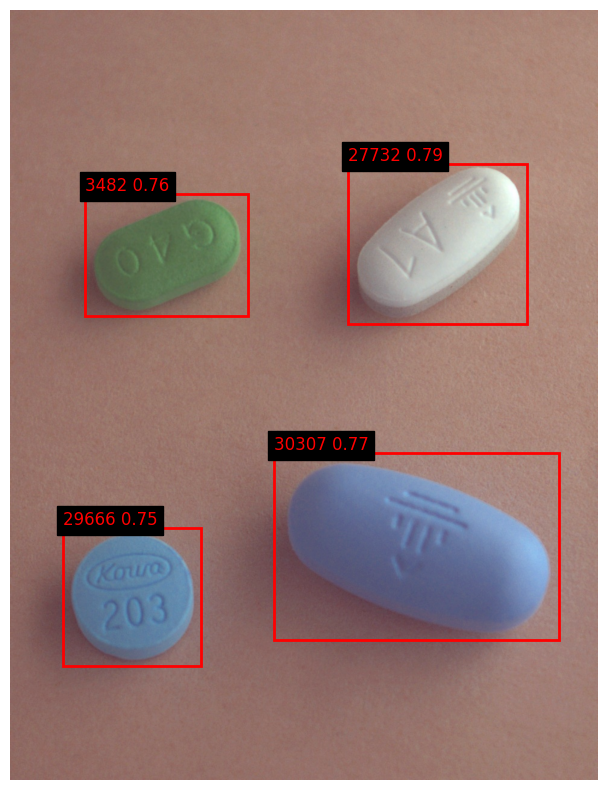

In [22]:
import matplotlib.patches as patches

img = result[0].orig_img.copy()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

for box in result[0].boxes:
    cls_idx, predicted_class, xyxy = search_class_idx(img, box)
    print(f"Predicted class : [{cls_idx}]  {predicted_class} {xyxy}")
    xyxy = box.xyxy[0].cpu().numpy().astype(int)
    cls = int(box.cls.item())
    conf = box.conf.item()
    label = f"{predicted_class} {conf:.2f}"
    color = 'red'  # 빨강색
    x1, y1, x2, y2 = xyxy
    # int()로 확실하게 정수 변환
    rect = patches.Rectangle((int(x1), int(y1)), int(x2-x1), int(y2-y1),
                           linewidth=2, edgecolor=color, facecolor='none')
    print(f'[{cls}] {predicted_class} {xyxy} {conf:.2f}')
    ax.add_patch(rect)
    ax.text(int(x1), int(y1)-5, label, color=color, fontsize=12, backgroundcolor='black')

plt.axis('off')
plt.show()

In [ ]:
def convert_yolo_bbox_with_orig_img(xywh, orig_img, default_orig_size=(976, 1280)):
    """
    YOLO 좌표를 원본 좌표로 변환

    Args:
        xywh: YOLO 바운딩 박스 좌표 [center_x, center_y, width, height]
        orig_img: YOLO에서 처리된 이미지 (리사이즈된 상태, 보통 640x640)
        default_orig_size: 실제 원본 이미지 크기 (width, height)

    Returns:
        tuple: (bbox_x, bbox_y, bbox_w, bbox_h) - 실제 원본 크기 기준 COCO 형식 좌표
    """

    orig_width, orig_height = default_orig_size
    yolo_height, yolo_width = orig_img.shape[:2]
    if yolo_height == orig_height and yolo_width == orig_width:
        # 리사이즈나 패딩이 없는 경우
        center_x, center_y, bbox_w, bbox_h = xywh
    else:
        # 리사이즈 및 패딩이 있는 경우 default_orig_size 기준 비율 유지 되었음으로 페딩을 제거하고 스케일 복원
        # default_orig_size -> orig_img 될 경우 패딩 계산 (비율 유지)
        # 페딩 제거 및 스케일 복원
        scale = min(yolo_width / orig_width, yolo_height / orig_height)
        resized_width = int(orig_width * scale)
        resized_height = int(orig_height * scale)
        pad_x = (yolo_width - resized_width) / 2
        pad_y = (yolo_height - resized_height) / 2

        center_x = (xywh[0] - pad_x) / scale
        center_y = (xywh[1] - pad_y) / scale
        bbox_w = xywh[2] / scale
        bbox_h = xywh[3] / scale

    # 중심점을 좌상단으로 변환
    bbox_x = center_x - bbox_w / 2
    bbox_y = center_y - bbox_h / 2

    # 경계 검사
    bbox_x = max(0, bbox_x)
    bbox_y = max(0, bbox_y)
    bbox_w = min(bbox_w, orig_width - bbox_x)
    bbox_h = min(bbox_h, orig_height - bbox_y)

    bbox_w = int(min(bbox_w, orig_width - bbox_x))
    bbox_h = int(min(bbox_h, orig_height - bbox_y))

    # 추가 검증
    if bbox_w <= 0 or bbox_h <= 0:
        print(f"Warning: Invalid bbox size - w:{bbox_w}, h:{bbox_h}")
        bbox_w = max(1, bbox_w)
        bbox_h = max(1, bbox_h)

    return int(bbox_x), int(bbox_y), int(bbox_w), int(bbox_h)

In [26]:
def save_detection_image_and_csv(image_path, save_folder, csv_rows):
    """이미지에서 약물을 검출하고 bbox와 label을 그려서 저장하며, CSV 데이터도 수집"""
    result = model_1way(image_path, verbose=False)

    # 이미지 ID (파일명에서 추출)
    image_id = os.path.splitext(os.path.basename(image_path))[0]

    # 해당 이미지의 실제 numpy 배열 가져오기
    current_img = result[0].orig_img.copy()

    # matplotlib으로 이미지 그리기
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(current_img)

    detection_count = 0
    annotation_id = len(csv_rows) + 1  # 전체 annotation_id 연속성 유지

    for box in result[0].boxes:
        cls_idx, predicted_class, xyxy = search_class_idx(current_img, box)

        # YOLO bbox 좌표
        x1, y1, x2, y2 = xyxy
        conf = box.conf.item()

        # 바운딩 박스 그리기
        rect = patches.Rectangle((int(x1), int(y1)), int(x2-x1), int(y2-y1),
                               linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # 라벨 텍스트
        label = f"{predicted_class} {conf:.2f}"
        ax.text(int(x1), int(y1)-5, label, color='red', fontsize=10,
                backgroundcolor='white', alpha=0.8)

        xywh = box.xywh[0].cpu().numpy()
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        bbox_x, bbox_y, bbox_w, bbox_h = convert_yolo_bbox_with_orig_img(
            xywh,
            result[0].orig_img,  # 실제 원본 이미지 전달
            default_orig_size=(976, 1280)  # 기본값
        )

        # #CSV 데이터 추가
        # bbox_x = float(x1)
        # bbox_y = float(y1)
        # bbox_w = float(x2 - x1)
        # bbox_h = float(y2 - y1)
        score = float(conf)
        category_id = predicted_class

        csv_row = [
            annotation_id, image_id, category_id, bbox_x, bbox_y, bbox_w, bbox_h, score
        ]
        csv_rows.append(csv_row)

        detection_count += 1
        annotation_id += 1

    # 축과 여백 제거
    ax.set_xlim(0, current_img.shape[1])
    ax.set_ylim(current_img.shape[0], 0)  # y축 뒤집기
    ax.axis('off')
    plt.tight_layout(pad=0)

    # 저장 경로
    img_name = os.path.basename(image_path).split('.')[0]
    save_path = os.path.join(save_folder, f"result_{img_name}_2way.jpg")

    # 이미지 저장
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=150, format='jpg')
    plt.close()  # 메모리 절약

    return save_path, detection_count

def save_all_detection_images():
    """모든 테스트 이미지에 대해 검출 결과를 이미지로 저장하고 CSV 파일도 생성"""
    import pandas as pd

    # 결과 저장 폴더 생성
    timestamp = datetime.now(__kst).strftime("%Y%m%d_%H%M%S")
    result_folder_name = f'result_{timestamp}'

    # output_path 설정 (기존 csv_path와 같은 위치)
    output_folder = os.path.join(drive_root(),
                                'codeit_ai_health_eat',
                                'scripts',
                                '김명환',
                                result_folder_name)

    # 폴더 생성
    os.makedirs(output_folder, exist_ok=True)

    print(f"검출 결과 이미지 저장 및 CSV 생성 시작...")
    print(f"저장 폴더: {output_folder}")

    # CSV 관련 변수
    csv_rows = []
    csv_headers = ['annotation_id', 'image_id', 'category_id', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'score']

    saved_images = []
    total_detections = 0

    for i, image_path in enumerate(tqdm(test_images, desc="이미지 검출 및 저장")):
        try:
            # 검출 결과 이미지 저장 및 CSV 데이터 수집
            saved_path, detection_count = save_detection_image_and_csv(image_path, output_folder, csv_rows)
            saved_images.append(saved_path)
            total_detections += detection_count

        except Exception as e:
            print(f"이미지 저장 실패 {image_path}: {e}")
            continue

    # CSV 파일 저장
    if csv_rows:
        df = pd.DataFrame(csv_rows, columns=csv_headers)
        csv_filename = f'predictions_2way_model_{timestamp}.csv'
        csv_path = os.path.join(output_folder, csv_filename)
        df.to_csv(csv_path, index=False)

        print(f"\n검출 결과 저장 완료:")
        print(f"- 처리된 이미지: {len(saved_images)}개")
        print(f"- 총 검출 객체: {total_detections}개")
        print(f"- 저장 폴더: {output_folder}")
        print(f"- CSV 파일: {csv_path}")

        # 결과 미리보기
        print(f"\nCSV 결과 미리보기:")
        print(df.head(10))

        # 클래스별 통계
        print(f"\n클래스별 검출 통계:")
        class_counts = df['category_id'].value_counts().head(10)
        print(class_counts)

        return output_folder, saved_images, df, csv_path
    else:
        print("검출된 객체가 없어 CSV 파일이 생성되지 않았습니다.")
        return output_folder, saved_images, None, None

# 실행
output_path, saved_images, results_df, csv_path = save_all_detection_images()

검출 결과 이미지 저장 및 CSV 생성 시작...
저장 폴더: /content/drive/MyDrive/codeit_ai_health_eat/scripts/김명환/result_20250916_153637


이미지 검출 및 저장: 100%|██████████| 843/843 [07:28<00:00,  1.88it/s]


검출 결과 저장 완료:
- 처리된 이미지: 843개
- 총 검출 객체: 3233개
- 저장 폴더: /content/drive/MyDrive/codeit_ai_health_eat/scripts/김명환/result_20250916_153637
- CSV 파일: /content/drive/MyDrive/codeit_ai_health_eat/scripts/김명환/result_20250916_153637/predictions_2way_model_20250916_153637.csv

CSV 결과 미리보기:
   annotation_id image_id  category_id      bbox_x      bbox_y  bbox_w  \
0              1     1018        27732  561.430176  256.580261     297   
1              2     1018        30307  438.656494  736.227417     473   
2              3     1018         3482  125.043274  306.764893     270   
3              4     1018        29666   87.117493  861.473999     230   
4              5      754         3831   85.884735  648.893799     371   
5              6      754        29666  627.141663  759.818604     228   
6              7      754         3350  373.718933  195.613464     183   
7              8      989        16550  591.025818  193.332642     259   
8              9      989         3482  570.574219  8